In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3,4,5,6,7' 
# os.environ['export']=' DISPLAY=127.0.0.1:2.0'
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import h5py
import time
from utilities import *
from mputilities import *
import torch.multiprocessing as mp
import libtorch_staggerfd_cuda
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP



In [2]:
# model_list=h5py.File('shot25.5am2.mat')  
# shot2 = model_list['shot2'][:].astype('float32').transpose(2,0,1)
# shot2.shape
# np.linspace(1,200,5000-24).shape
# shot2interp=np.zeros((4976,17,17))
# for i in range(17):
#     for j in range(17):
#         shot2interp[:,i,j] = np.interp(np.linspace(1,200,5000-24),np.linspace(1,200,200),shot2[15:215,i,j])
# shot2interp = torch.from_numpy(shot2interp) 
# imagesc(shot2interp[:,:,0])

In [3]:
model_list=h5py.File('testmodel.mat')  
vp_RM = torch.from_numpy(model_list['vp'][:].astype('float32')).T
vs_RM = torch.from_numpy(model_list['vs'][:].astype('float32')).T
# model_list=h5py.File('newFWI51.mat')  
# randn_noise = torch.from_numpy(model_list['randn_noise'][:].astype('float32').transpose(0,2,1))
# randn_noise.shape

In [4]:
vp_RM.shape

torch.Size([40, 161])

40 161


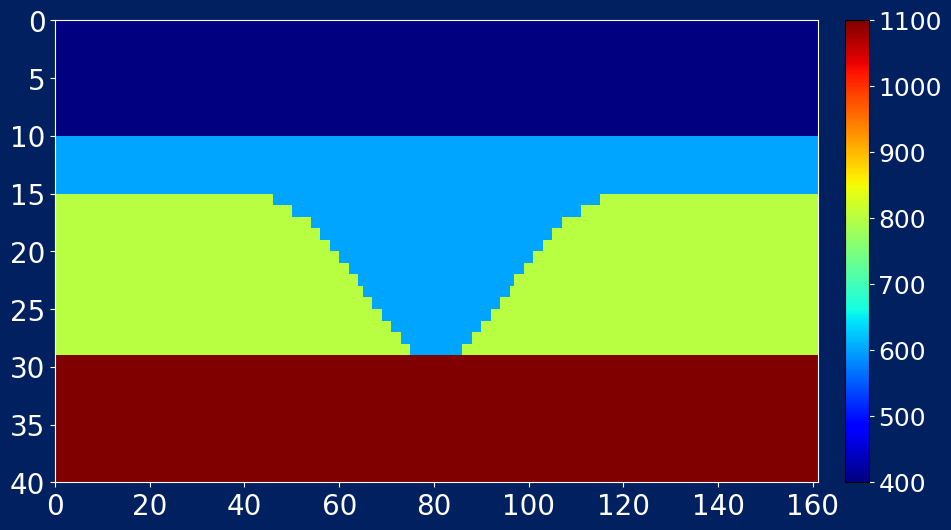

In [5]:
[nz,nx]=vp_RM.shape  #nz：深度网格点数，nx测线方向网格点数
print(nz,nx)
nbc=80                  #吸收边界长
dx=0.2                  #一网格点对应深度
dt=dx/torch.max(vp_RM)*0.5  #公式

nt=2500

fr=50              #频率

pad_top = 2
ds=10
sx=torch.arange(0,nx,ds)
sz=torch.zeros(sx.shape)+1      #炮点位置
ns=sx.numel()
dg=10
gx=torch.arange(0,nx,dg)
ng=gx.numel()
gz=torch.zeros(gx.shape)+1
isFS=1
sx=sx+nbc
sz=sz+pad_top
gx=gx+nbc
ns = len(sx)
gz=gz+pad_top
seismo_v_d=torch.zeros((ns,nt,ng)).to('cuda')
imagesc(vp_RM)
#     vp(:,i)=linspace(1.5357300e+03,2.6852700e+03,nz);
#     vs(:,i)=linspace(7.6786499e+02,1.3426350e+03,nz);   
vpmax=torch.max(vp_RM)
vpmin=torch.min(vp_RM)
vsmax=torch.max(vs_RM)
vsmin=torch.min(vs_RM)
[nz,nx] = vp_RM.shape
asd = torch.linspace(vpmin,vpmax,nz).view(-1,1)
vp0 = asd.repeat(1,nx)
asd = torch.linspace(vsmin,vsmax,nz).view(-1,1)
vs0 = asd.repeat(1,nx)
torch.set_printoptions(precision=10)
maxlinep = vpmax*torch.ones_like(vp0)
minlinep = vpmin*torch.ones_like(vp0)
maxlines = vsmax*torch.ones_like(vp0)
minlines = vsmin*torch.ones_like(vp0)

wahtwahtwahtwhatwhtatwhta
vp_RM
vs_RM
s
sx
sz
gx
gz
maxlinep
minlinep
maxlines
minlines
den
input_vector
temp
vp0
vs0
denm2
denm0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
cuda:0


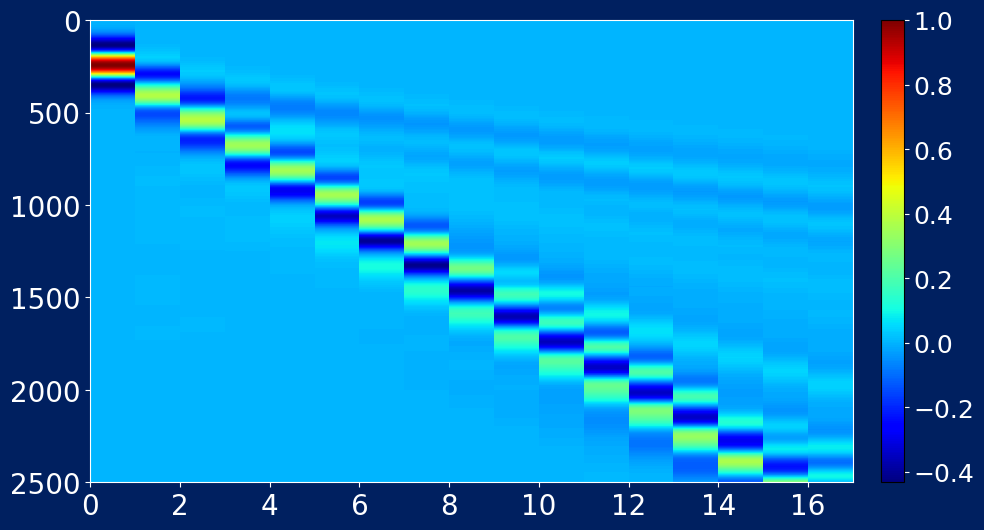

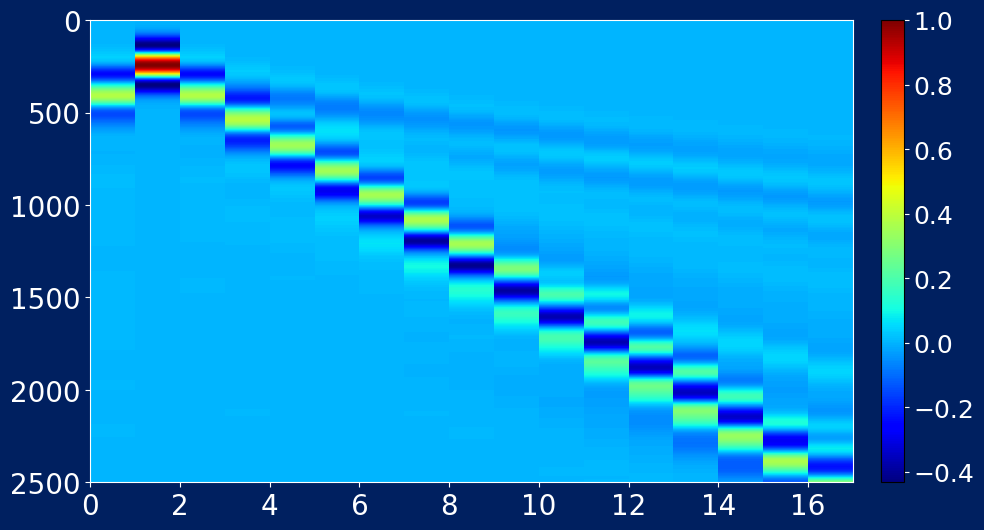

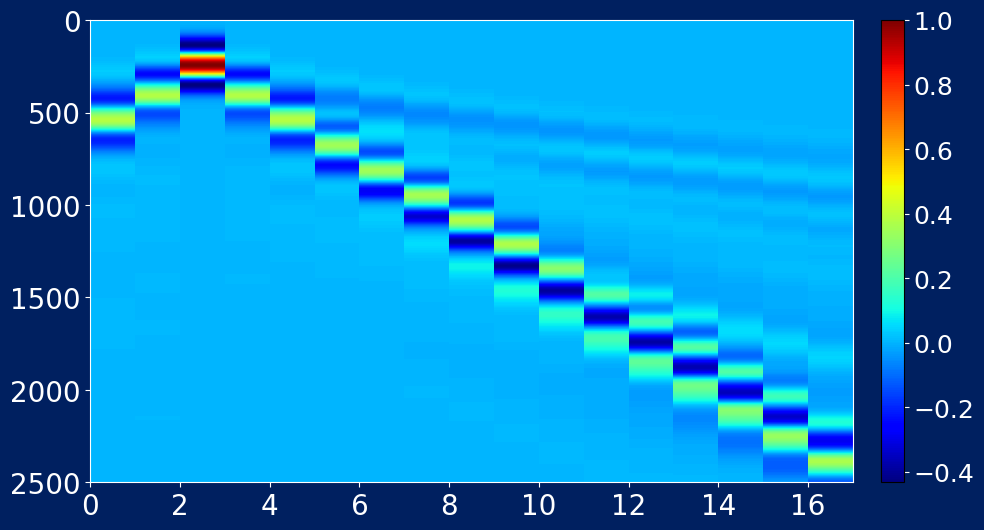

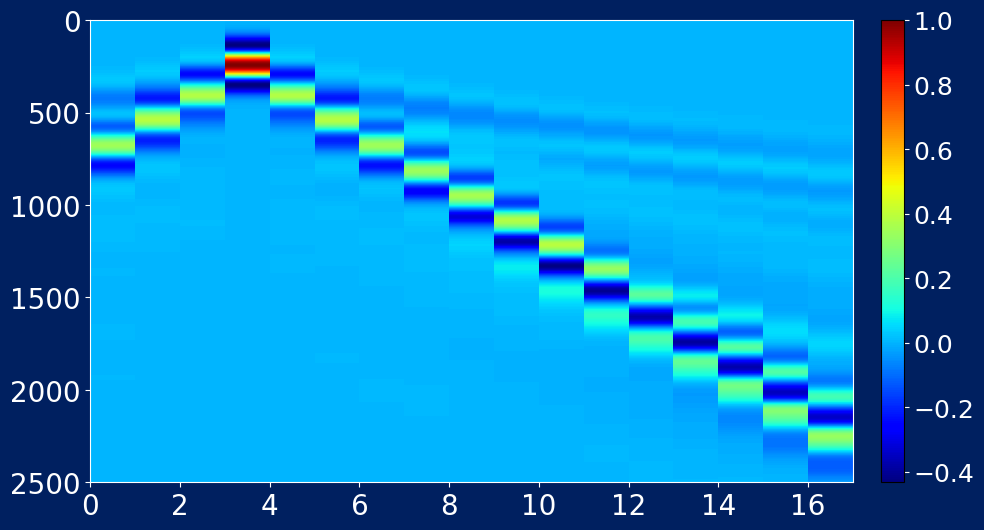

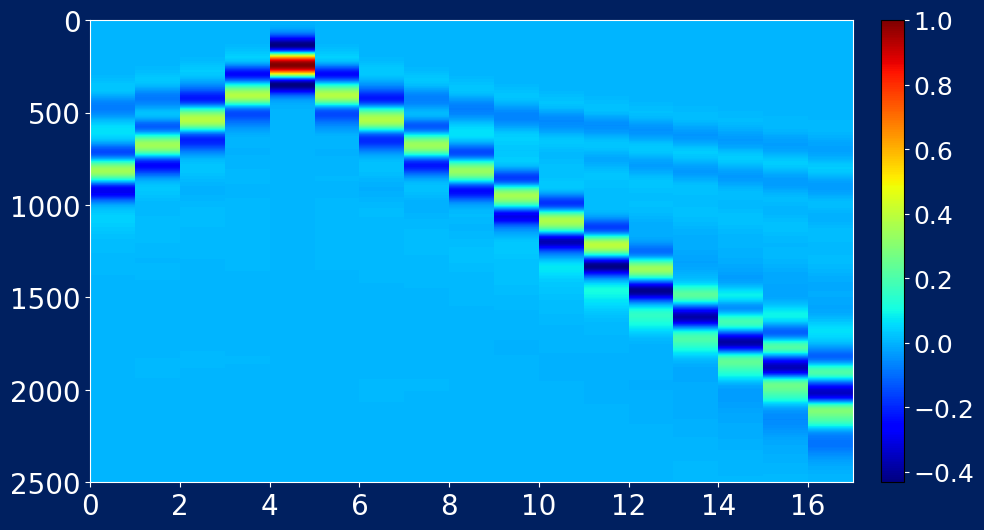

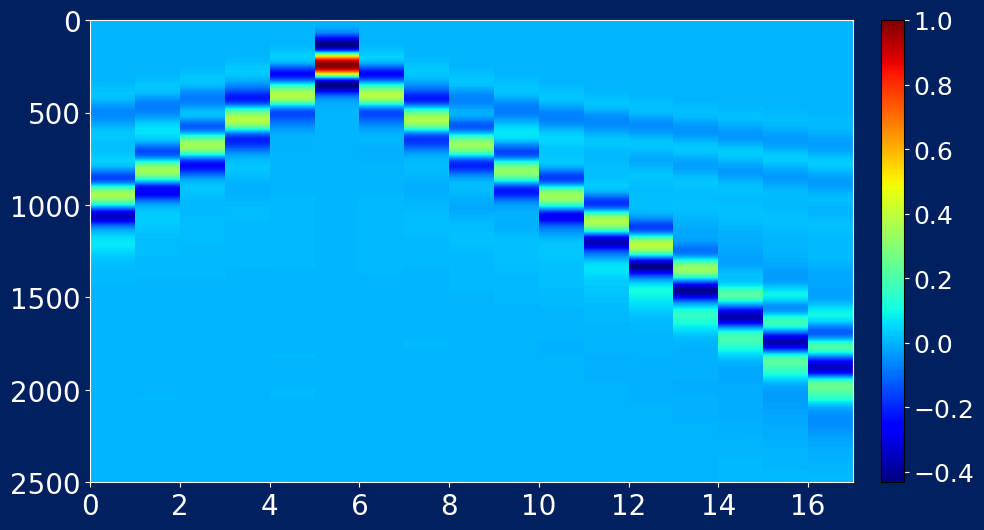

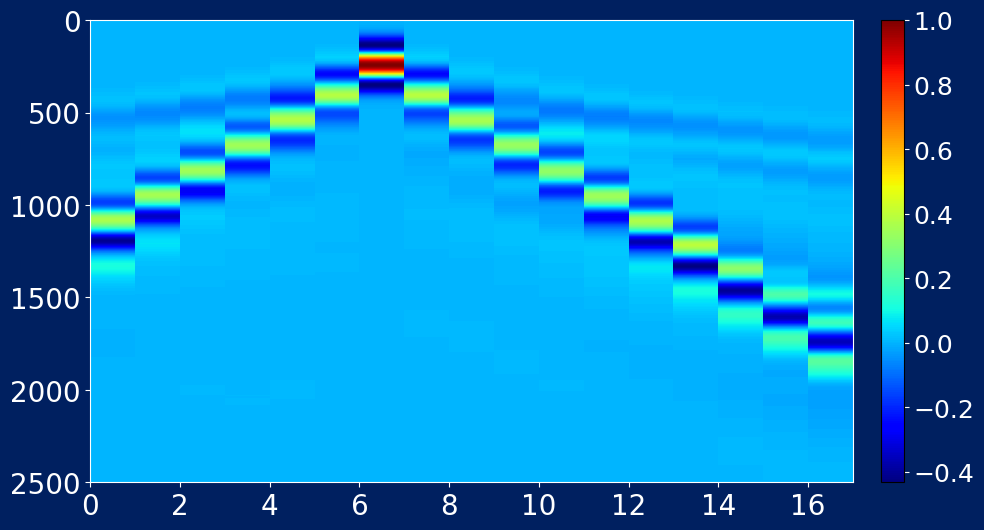

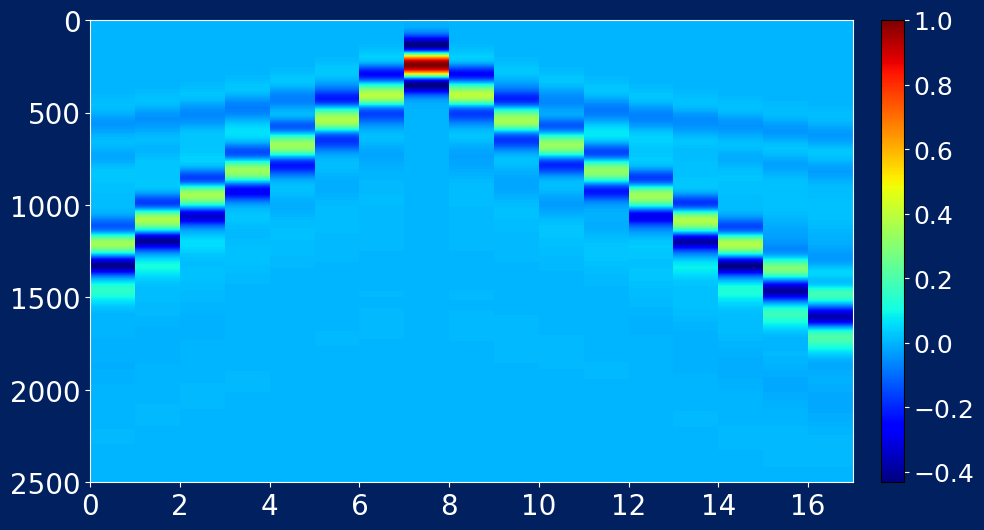

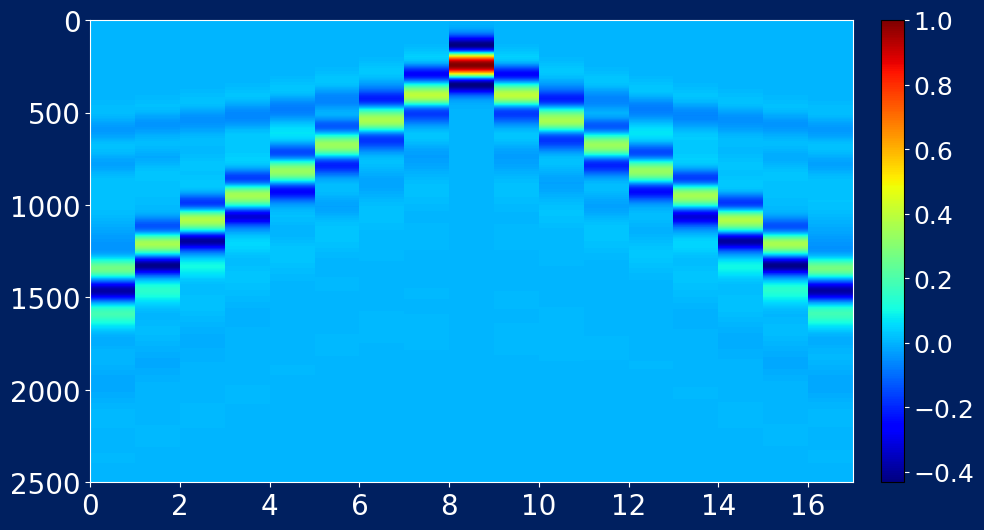

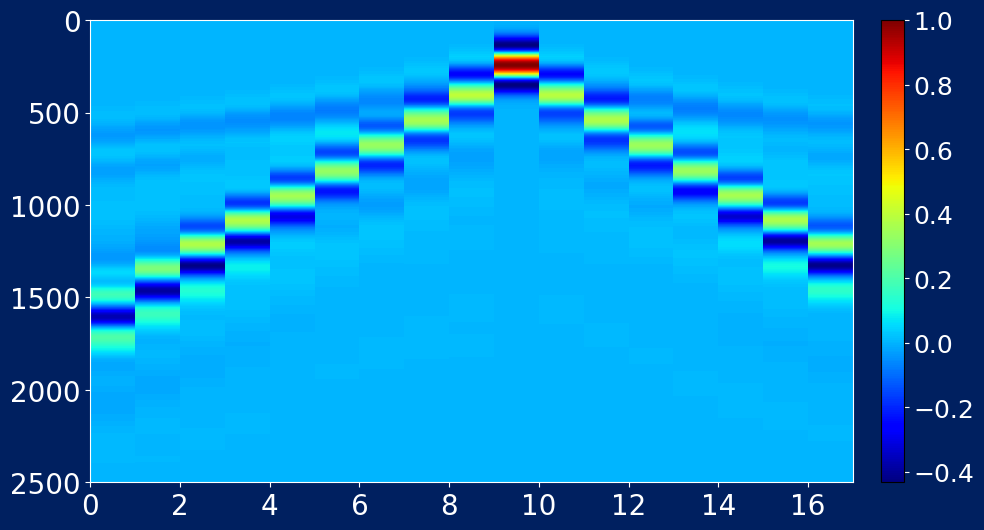

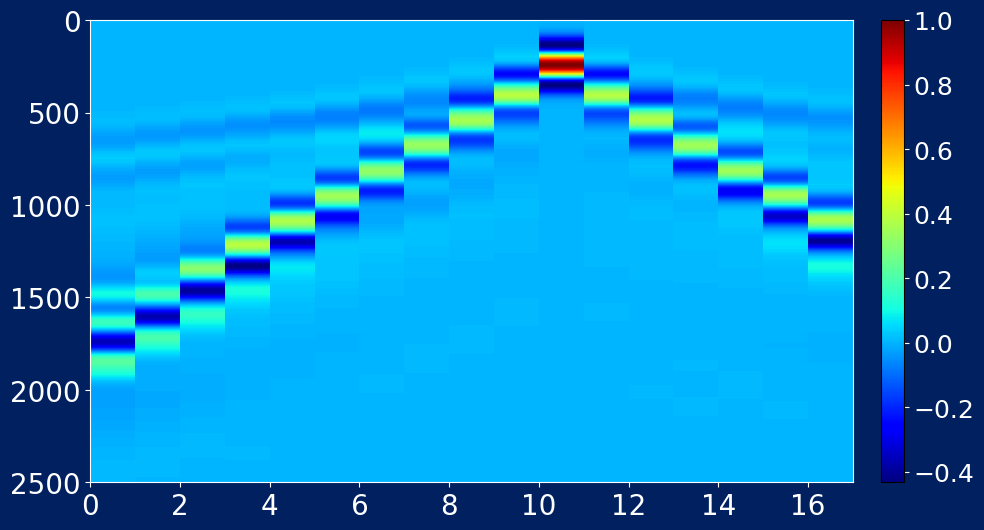

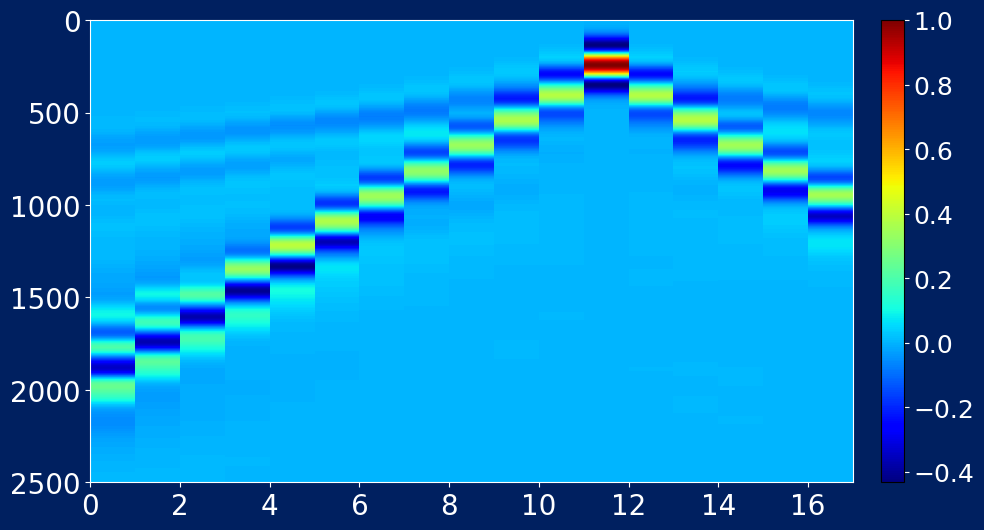

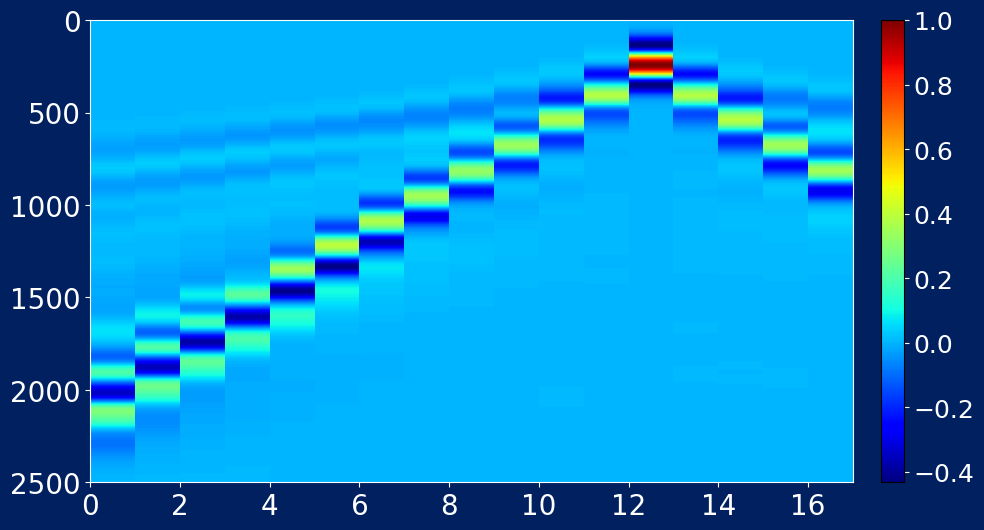

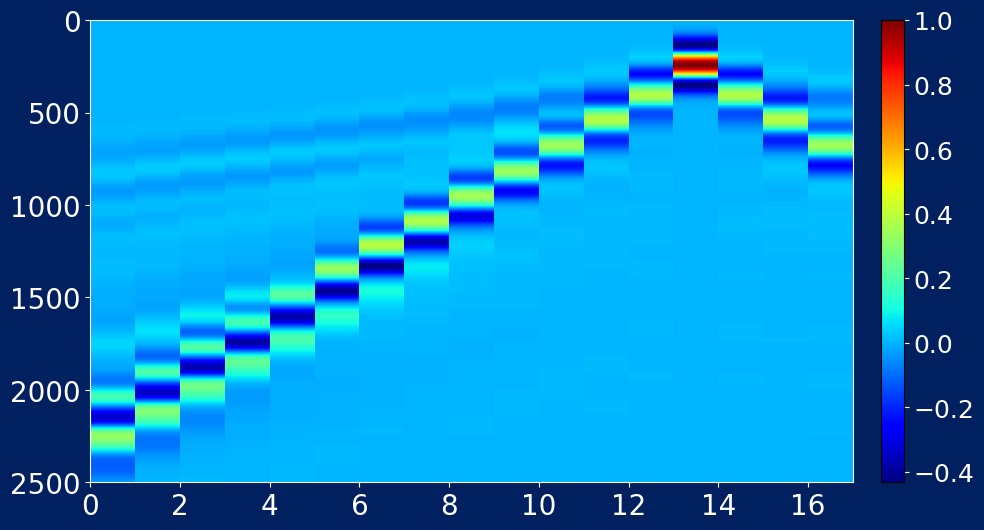

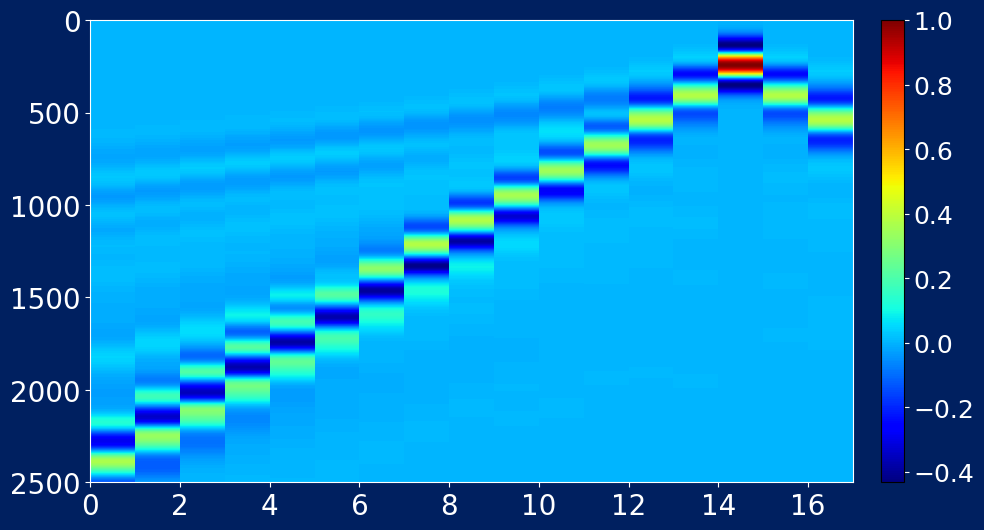

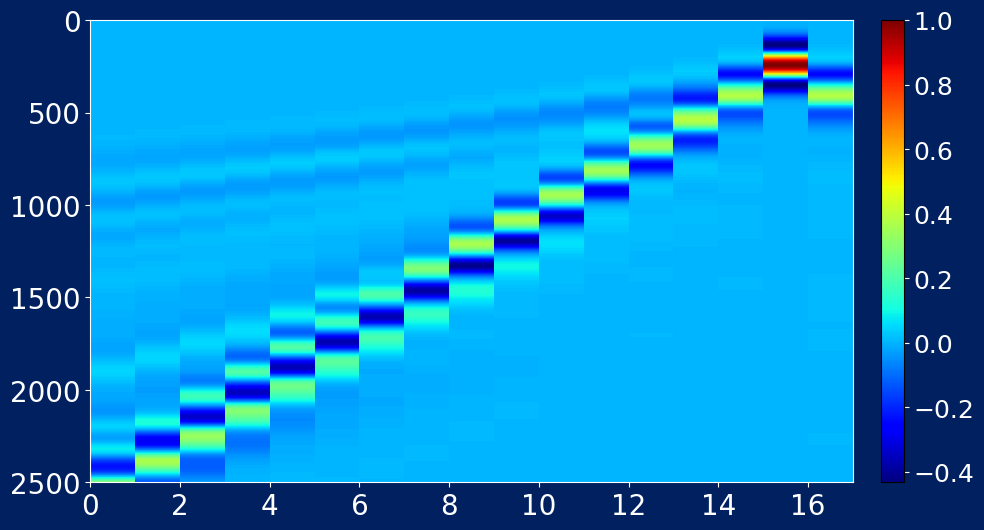

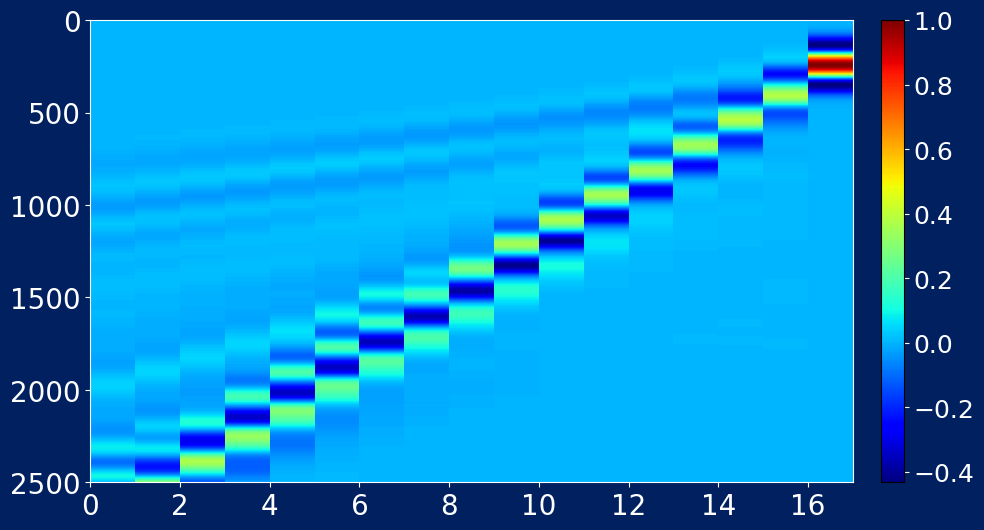

In [6]:
damp=damp_circle(vsmin,nz+pad_top+nbc,nx+nbc+nbc,nbc,dx,1,pad_top)
temp = 1-damp*dt
s = ricker(nt,fr,dt)

dtx = float(dt/dx)

nzbc = nz + nbc + pad_top
nxbc = nx + nbc + nbc
source_type_num = 5
fd_order_num = 22
in_wf = 1
format_num = 2

input_vector = torch.tensor([nt,nzbc,nxbc,dtx,ng,int(sz[0]),int(sx[0]),int(gz[0]),int(gx[0]),int(gx[1]-gx[0]), \
                            source_type_num,fd_order_num,in_wf,nz,nx,format_num,nbc,pad_top])

print('wahtwahtwahtwhatwhtatwhta')
denm2 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc))
denm2[pad_top-1,:]=2*denm2[pad_top-1,:]

denm0 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc))
denm0[pad_top-1,:]=0.0
# serial
device=0

n_proc = ns 
device_num = 5
nbc = int(input_vector[16].clone())
pad_top = int(input_vector[17].clone())
den = pad(torch.ones_like(vp0,device=torch.device('cuda', device)),nbc,pad_top)
dtx = input_vector[3].clone()
for le in ['vp_RM','vs_RM','s','sx','sz','gx','gz','maxlinep','minlinep','maxlines','minlines', \
    'den','input_vector','temp','vp0','vs0','denm2','denm0']:
    print(le)
    exec(le + '=' + le + '.to("cuda:0")')
vp1 = pad(vp_RM,nbc,pad_top)
vs1 = pad(vs_RM,nbc,pad_top)
ca=torch.mul(vp1**2,den)
cm=torch.mul((vs1**2),den)
cl=ca - 2*cm
den1 = den
cm1=cm
cl = cl * denm0
cam = torch.zeros_like(ca, device=torch.device('cuda', device))
cam[pad_top-1,:] = 2 * cm[pad_top-1,:] - ca[pad_top-1,:]
ca = ca + cam
b=dtx*torch.reciprocal(den)
b = b * denm2
b1=b
# print(sx)
for i in range(ns):
    print(i)
    input_vector[6] = int(sx[i])
    # [seismo_u,seismo_w,illum_div]=libtorch_staggerfd_cuda.forward(input_vector,temp,ca,cl,cm,cm1,b,b1,s,device)
    [uu1,seismo_w,illum_div1]=staggeredfd_py_cuda(input_vector,temp,ca,cl,cm,cm1,b,b1,s,device)
    seismo_v_d[i,:,:]=seismo_w
# seismo_v_d = Generate_obs_data(n_proc,device_num,vp_RM,vs_RM,input_vector,sx,temp,s)
for i in range(ns):
    imagesc(seismo_v_d[i,:,:])
    plt.savefig('./dk_vp_iter/vp' + str(i) + '.png')
print(seismo_v_d.device)







In [7]:
for i in range(ns):
    for ii in range(ng):
        seismo_v_d[i,:,ii] = seismo_v_d[i,:,ii]/torch.max(torch.abs(seismo_v_d[i,:,ii]))  

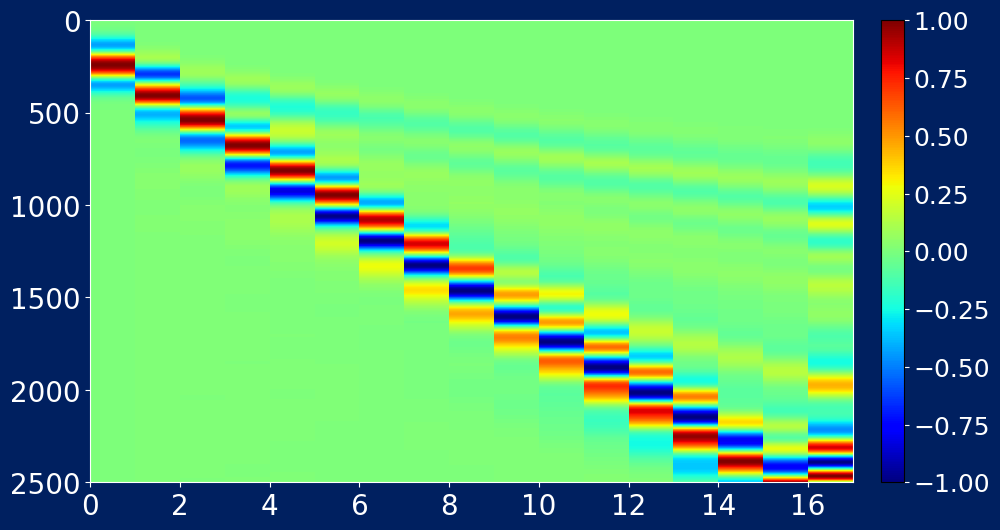

In [8]:
imagesc(seismo_v_d[0,:,:])

In [9]:
# seismo_v_d = seismo_v_d.cpu() + 0.3*randn_noise

In [10]:
for i in range(ns):
    for ii in range(ng):
        seismo_v_d[i,:,ii] = seismo_v_d[i,:,ii]/torch.max(torch.abs(seismo_v_d[i,:,ii]))  

cuda:0


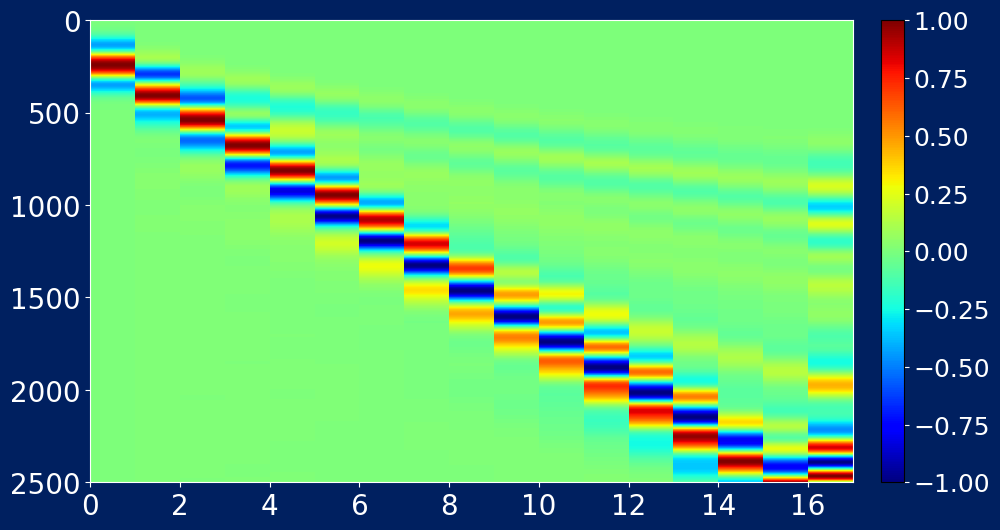

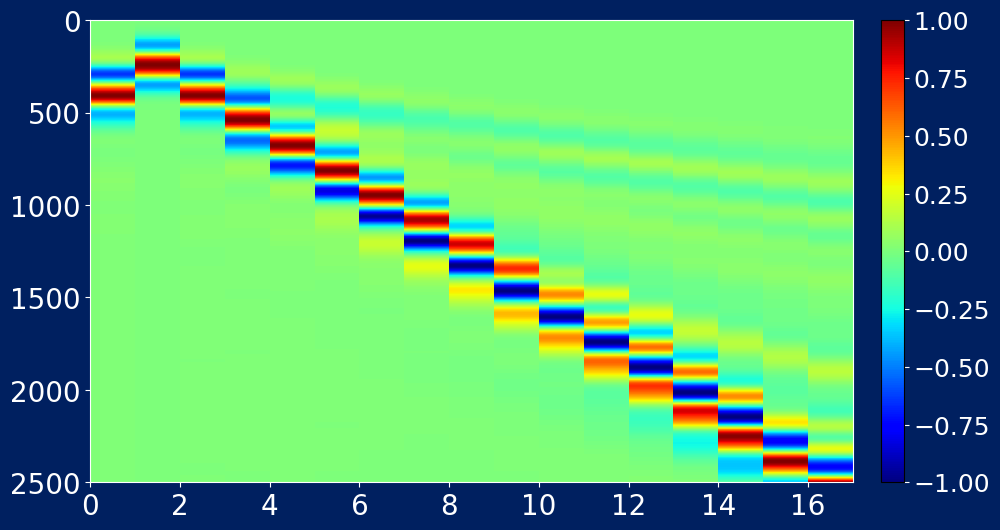

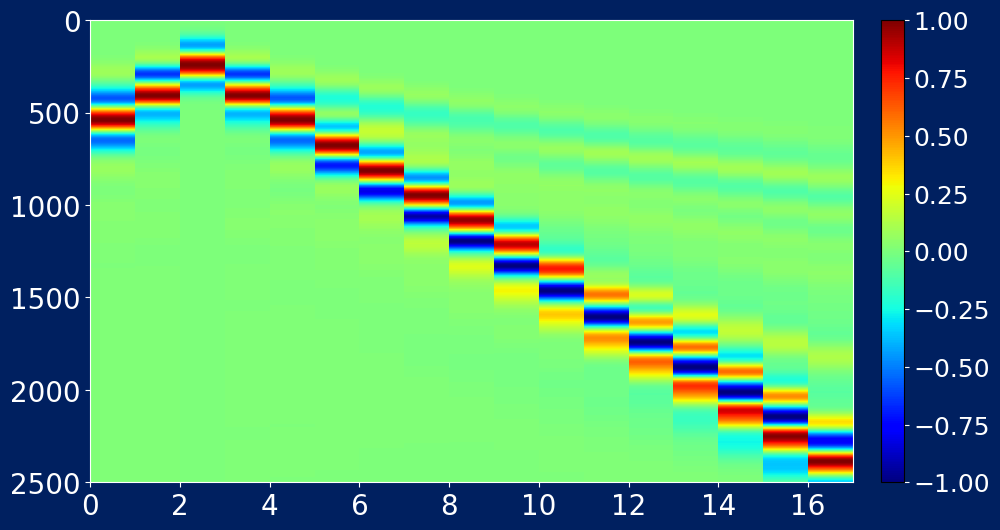

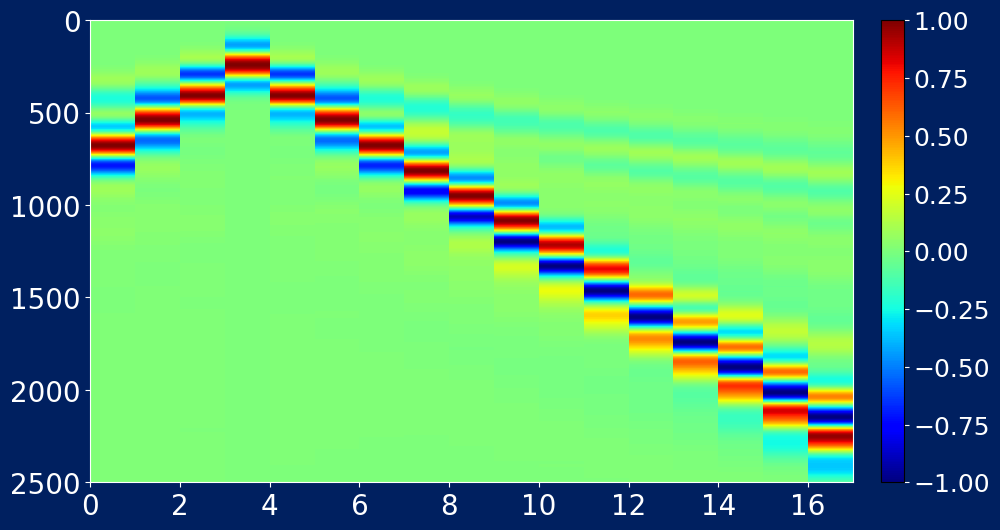

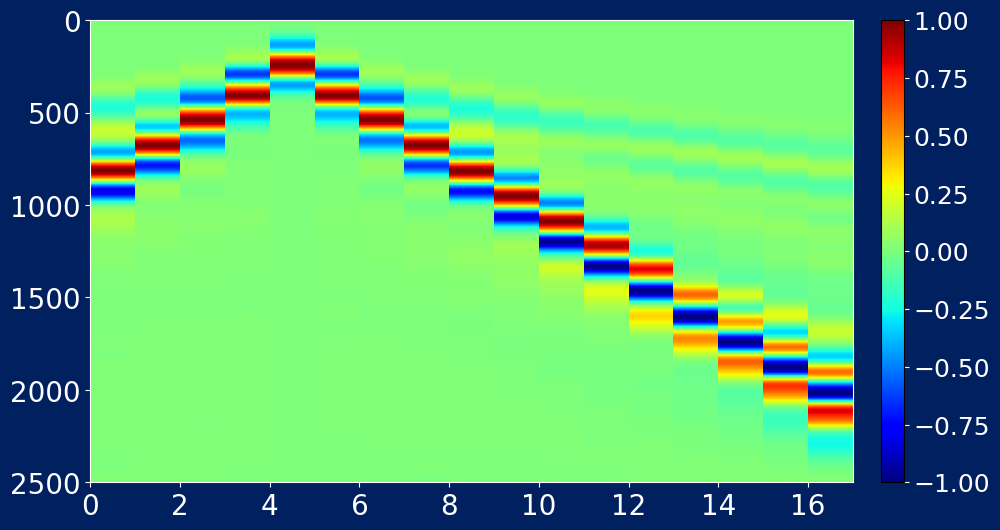

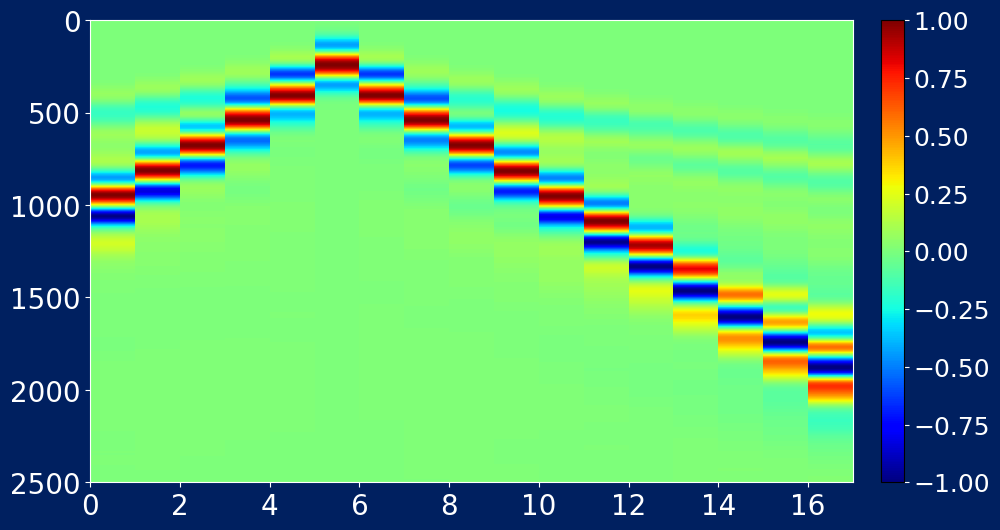

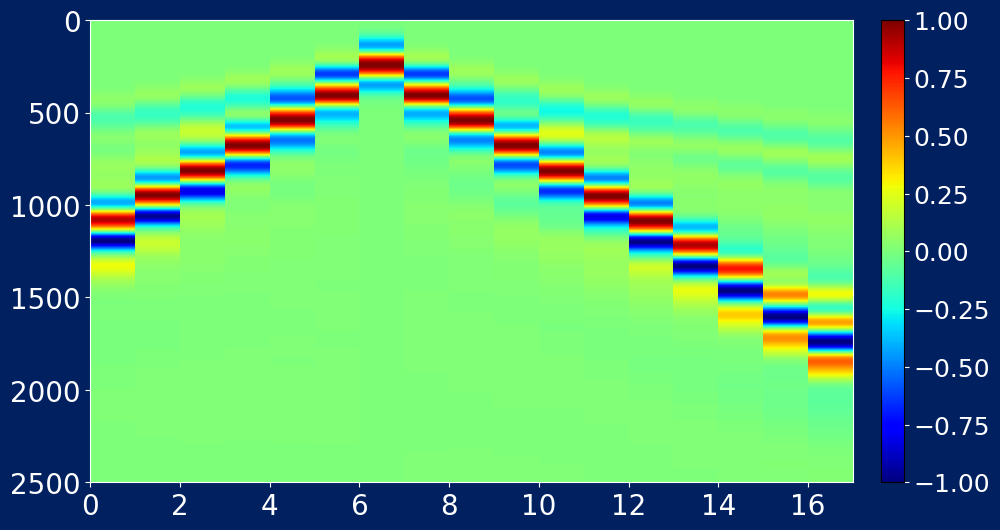

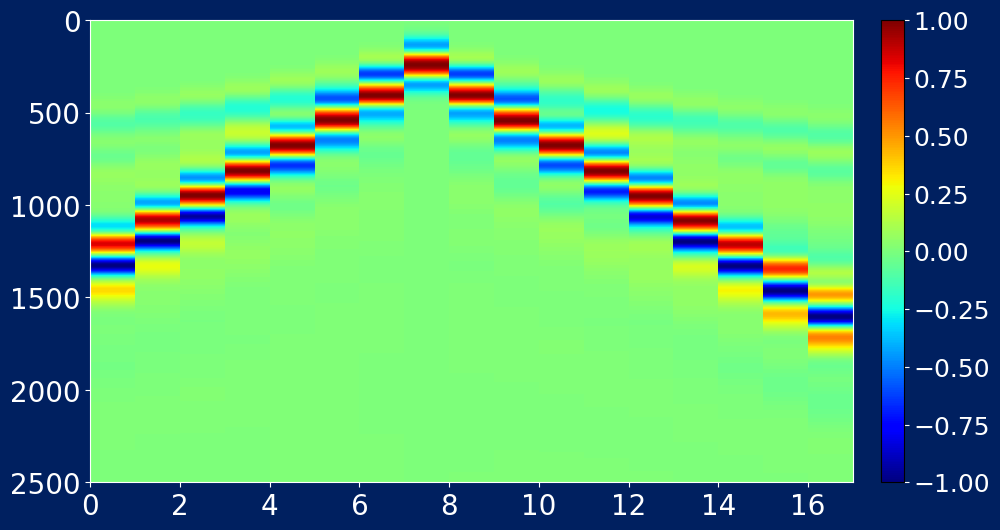

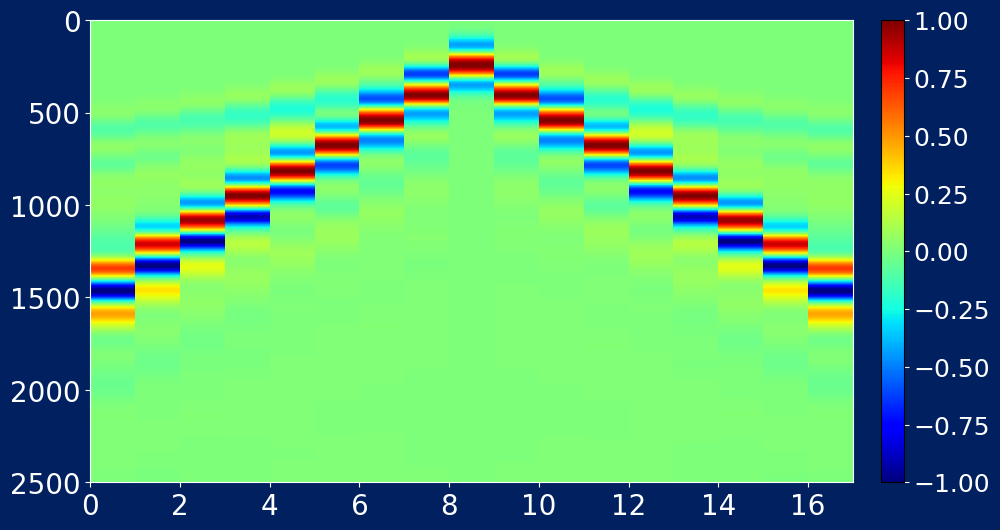

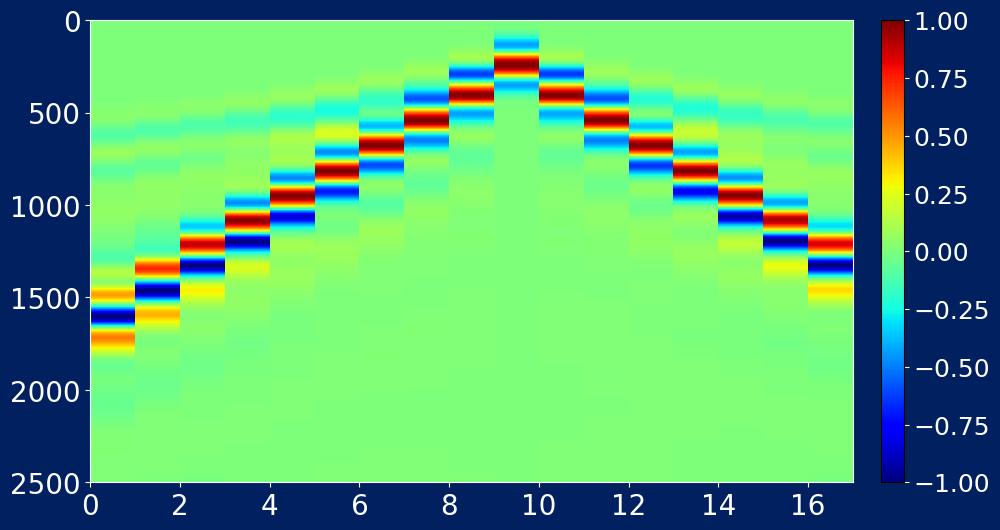

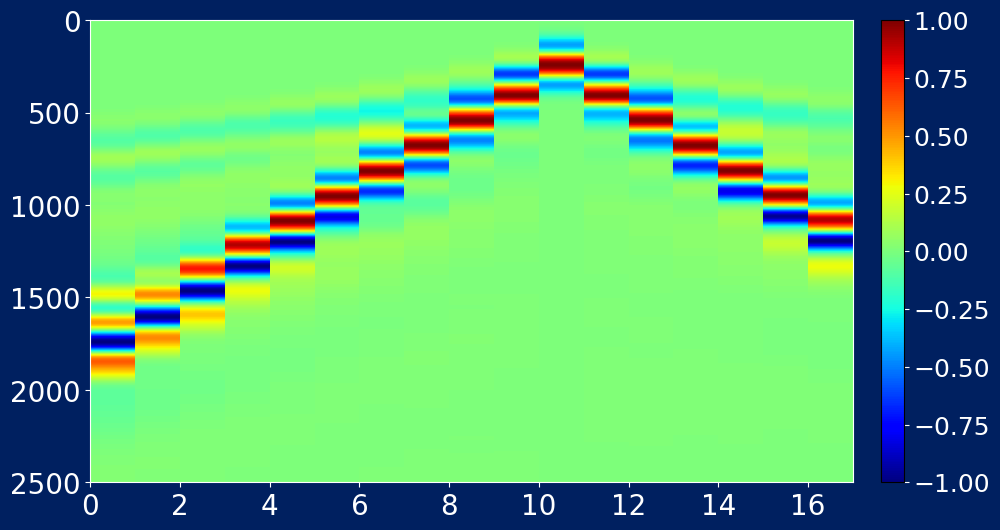

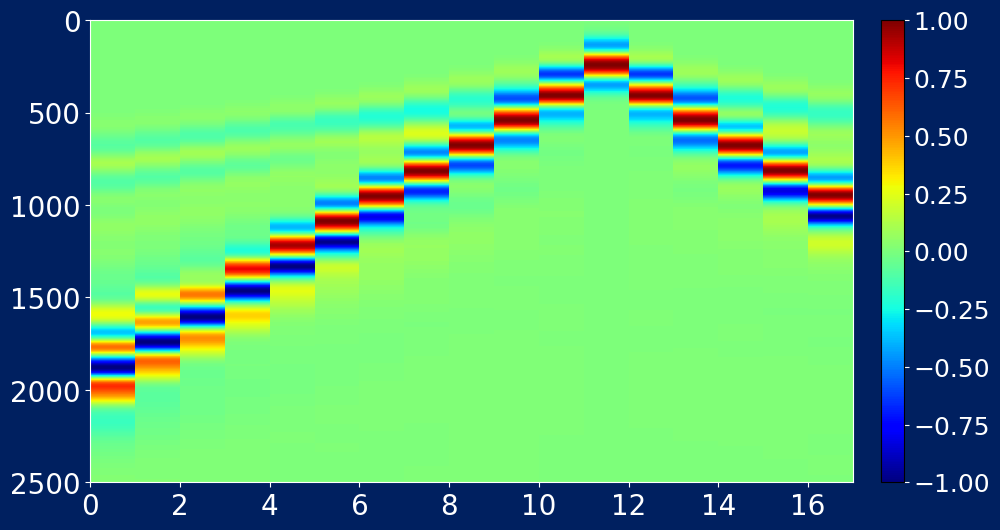

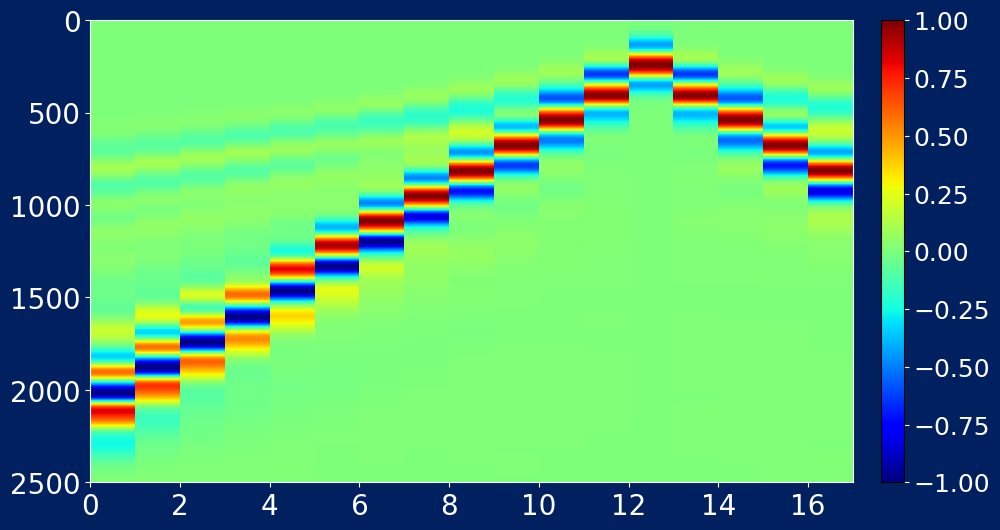

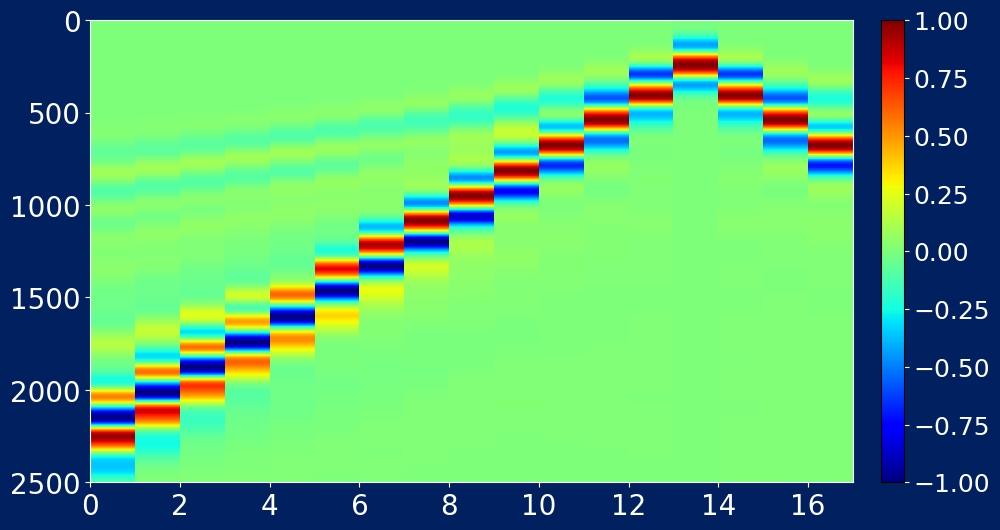

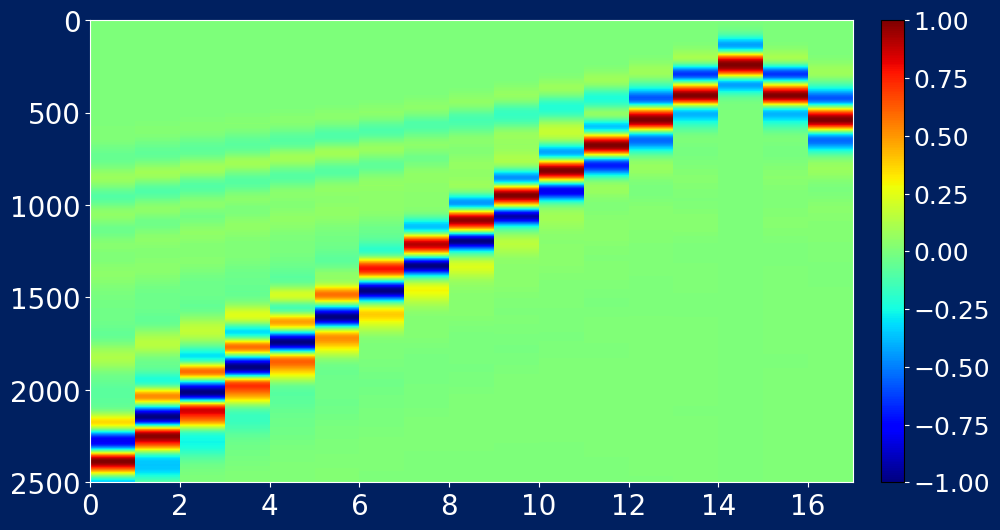

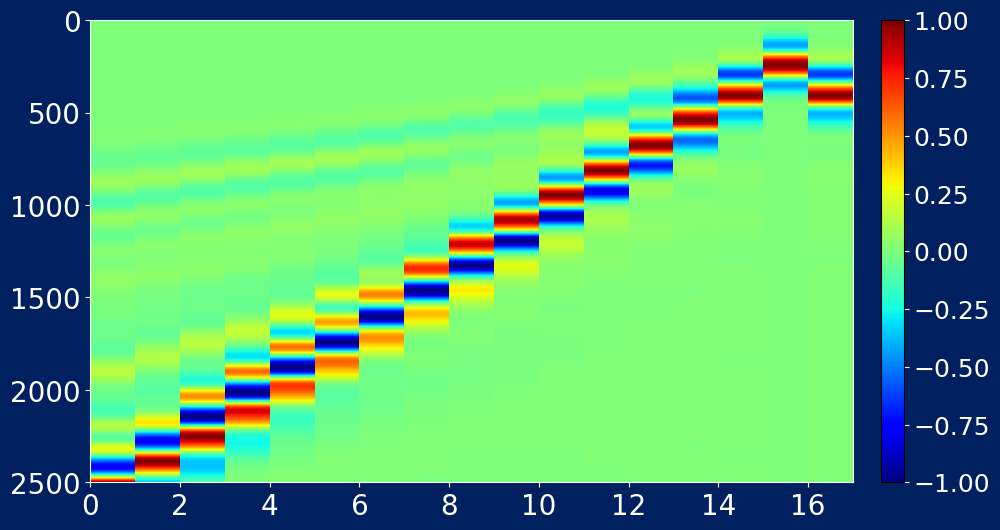

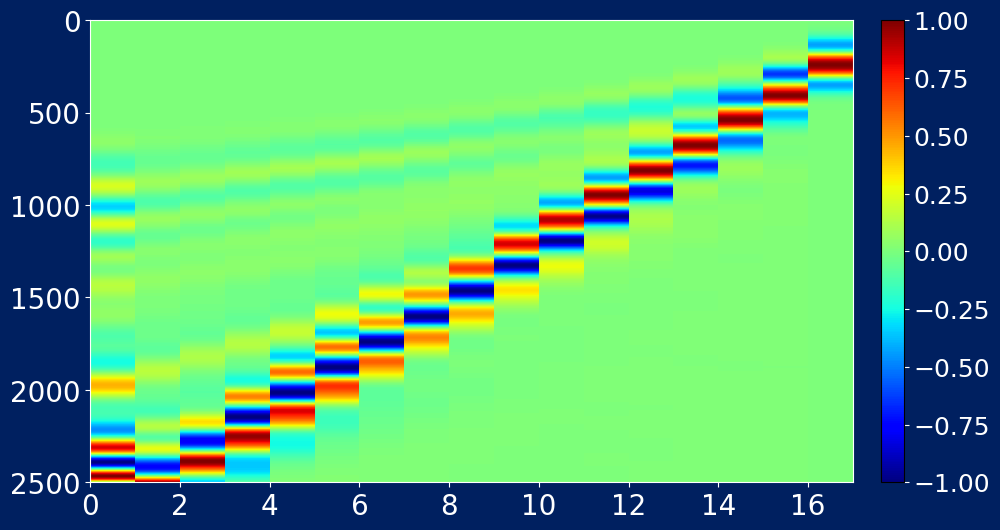

In [11]:
for i in range(ns):
    imagesc(seismo_v_d[i,:,:])
    plt.savefig('./dk_vp_iter/vp' + str(i) + '.png')
print(seismo_v_d.device)

In [12]:
torch.save({'seismo_v_d':seismo_v_d.detach().cpu().clone(),'input_vector':input_vector.detach().cpu().clone(), \
            's':s.detach().cpu().clone(),'sx':sx.detach().cpu().clone(),'vp0':vp0.detach().cpu().clone(), \
                'vs0':vs0.detach().cpu().clone(),'temp':temp.detach().cpu().clone(),'denm0':denm0.detach().cpu().clone(), \
                    'denm2':denm2.detach().cpu().clone(),'vpmax':vpmax.detach().cpu().clone(),'vpmin':vpmin.detach().cpu().clone(),\
                        'vsmax':vsmax.detach().cpu().clone(),'vsmin':vsmin.detach().cpu().clone()},'./modeltest3.pt')
print('dx',dx,'dt',dt,'seismo_v_d.shape',seismo_v_d.shape)
print('nbc',nbc,'vpmax',vpmax,'vpmin',vpmin,'vsmax',vsmax,'vsmin',vsmin)

dx 0.2 dt tensor(9.0909095888e-05) seismo_v_d.shape torch.Size([17, 2500, 17])
nbc 80 vpmax tensor(1100.) vpmin tensor(400.) vsmax tensor(314.2857055664) vsmin tensor(160.)


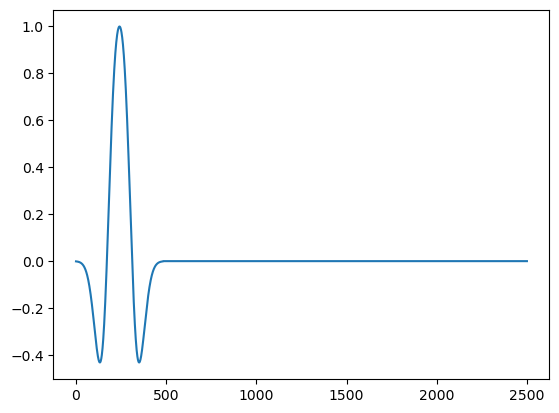

In [13]:
plt.plot(s.cpu().numpy())

In [25]:
!pwd

/home/zhangchang/python/ENFWImodeltest


In [6]:
taper1=torch.zeros_like(seismo_v_d)
taper=torch.zeros_like(seismo_v_d)

In [7]:
for i in range(ns):    
    [_,taper[i,:,:]]=GW_mute(seismo_v_d[i,:,:],2100,gx,sx[i],0,587.5000,dt,20)
    [_,taper1[i,:,:]]=GW_mute1(seismo_v_d[i,:,:],2100,gx,sx[i],0,3000,dt,20)   

In [8]:
for i in range(ns):    
    seismo_v_d[i,:,:] = bp_filter(seismo_v_d[i,:,:],dt,1,1,40,40+5)
    #         seismo_w = manual_pick(seismo_w,dt,gg,ng,p_ind)
    seismo_v_d[i,:,:] = seismo_v_d[i,:,:]*taper[i,:,:]*taper1[i,:,:]
    for ii in range(ng):
        seismo_v_d[i,:,ii]= seismo_v_d[i,:,ii]/torch.max(torch.abs(seismo_v_d[i,:,ii]))  

In [9]:
seismo_v_d1 = torch.nn.functional.normalize(seismo_v_d[0,:,:], p=2.0, dim=0)

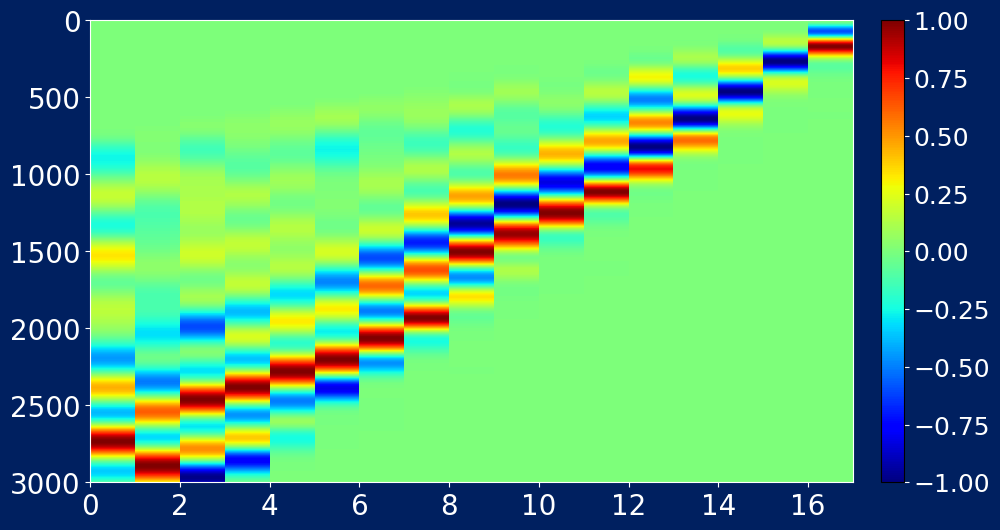

In [10]:
imagesc(seismo_v_d[i,:,:])

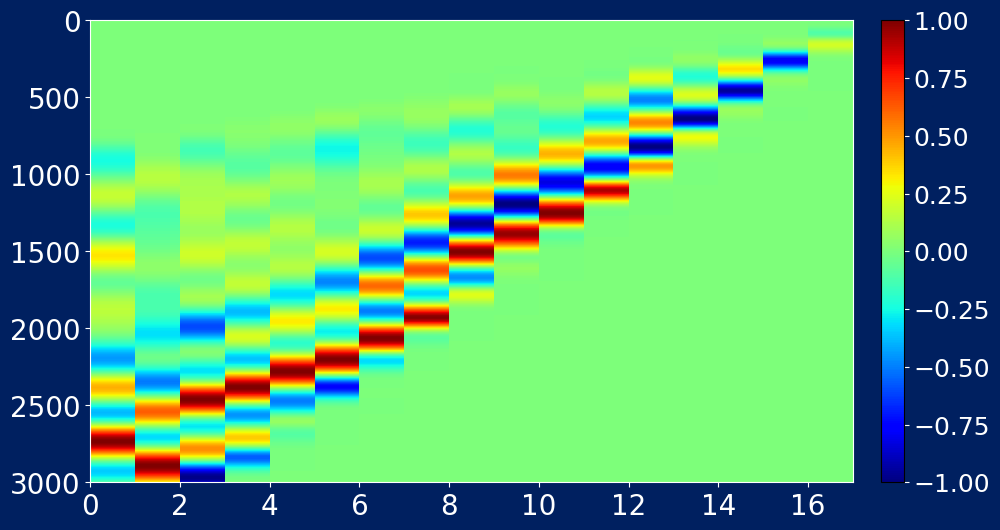

In [11]:
imagesc(seismo_v_d[i,:,:]*taper[i,:,:]*taper1[i,:,:])

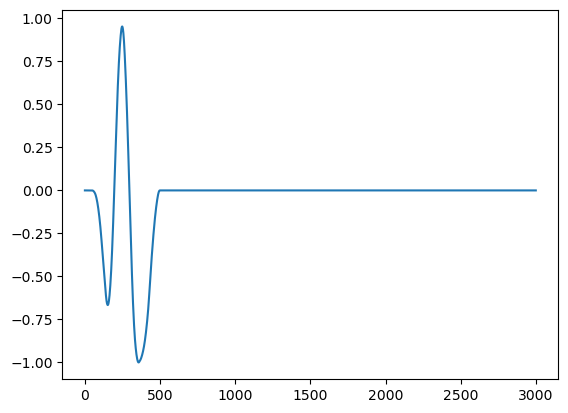

In [12]:
plt.plot(s.numpy())

wahtwahtwahtwhatwhtatwhta
cpu
dx 0.2 dt 8e-05 seismo_v_d.shape torch.Size([17, 3000, 17])
nbc 80 vpmax tensor(1300.) vpmin tensor(350.) vsmax tensor(561.5384521484) vsmin tensor(148.0769195557)


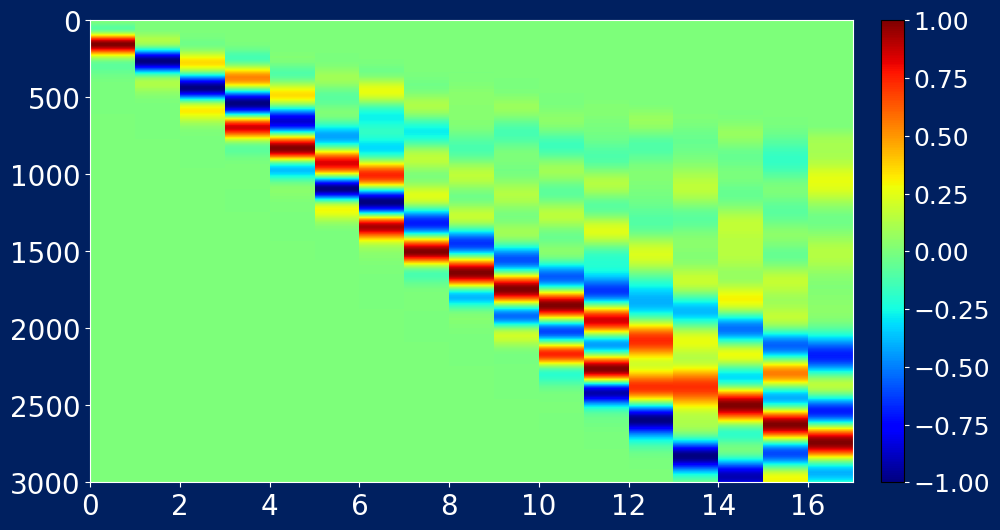

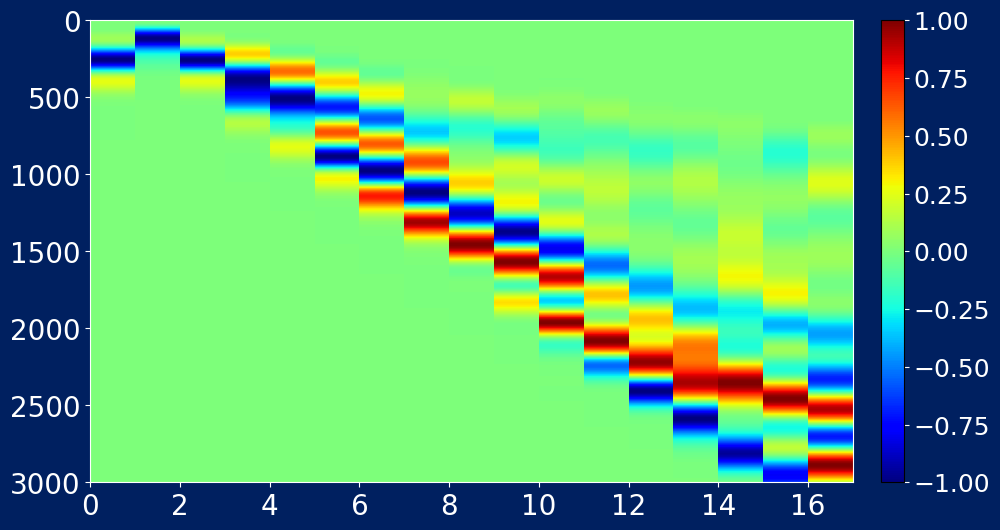

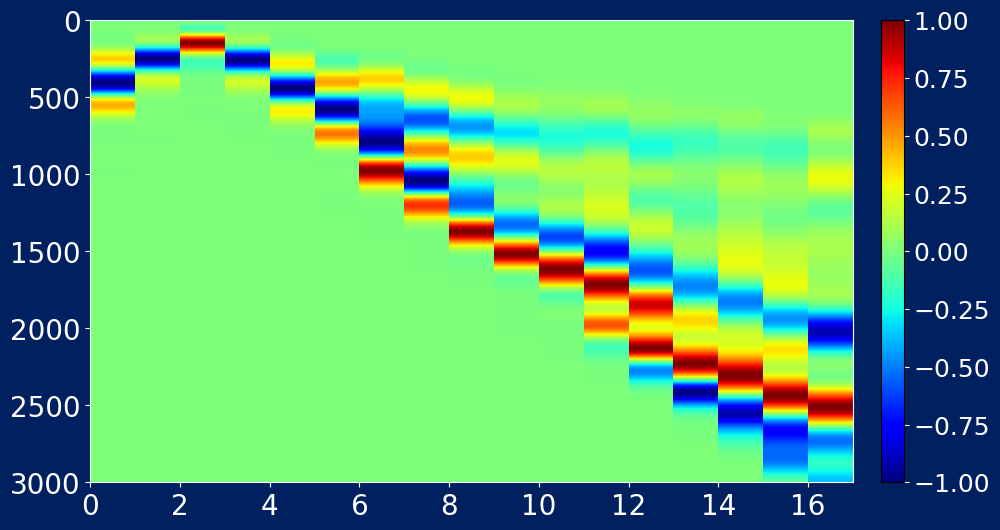

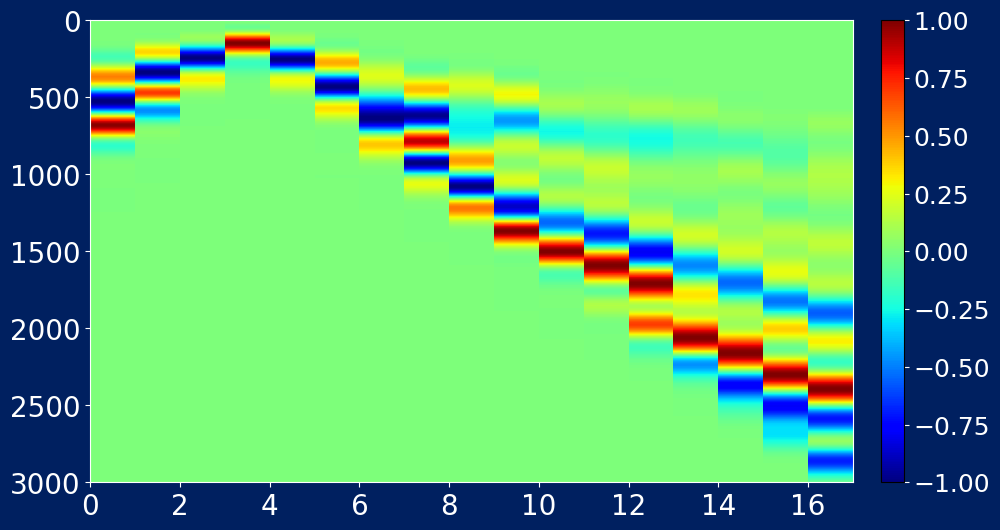

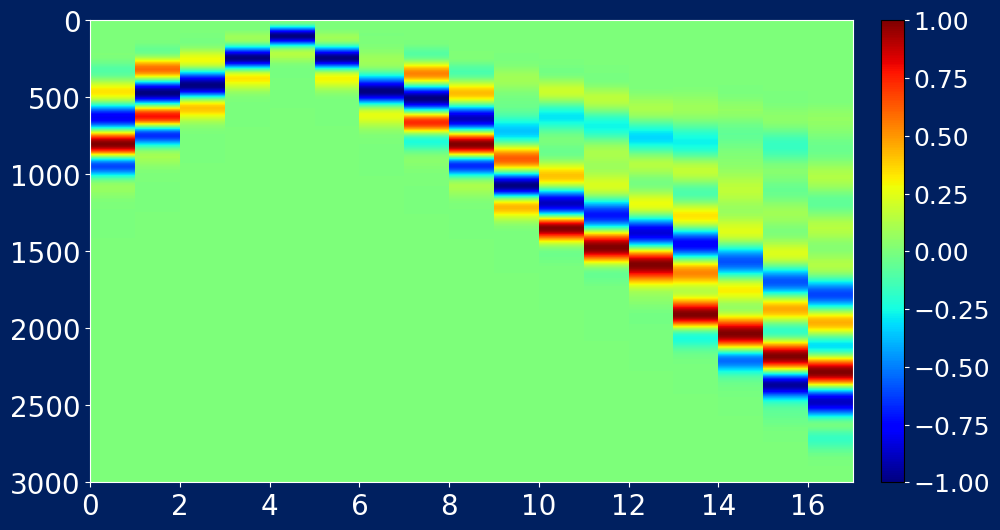

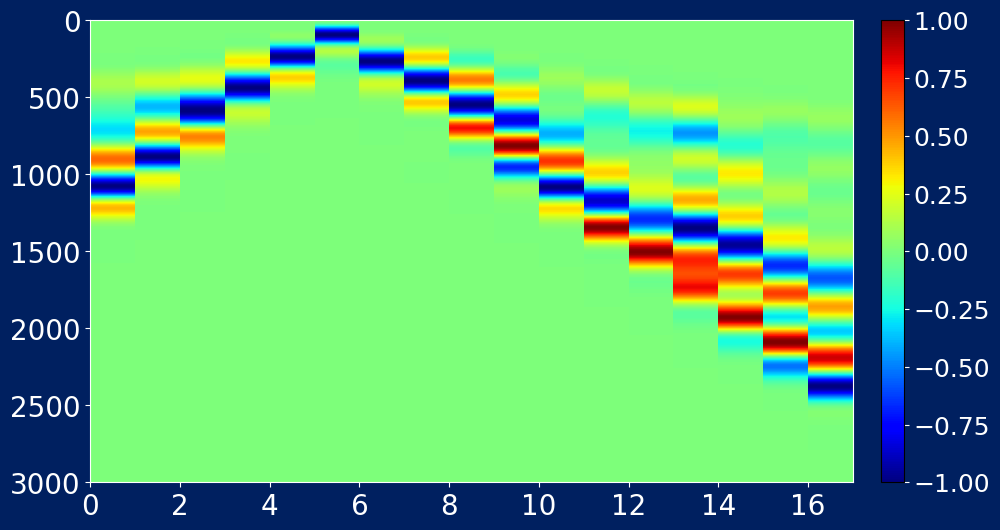

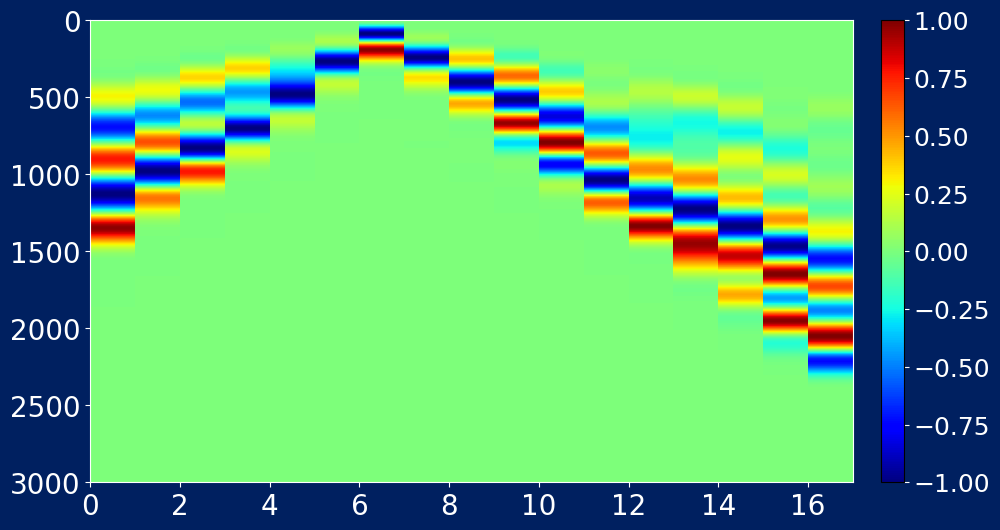

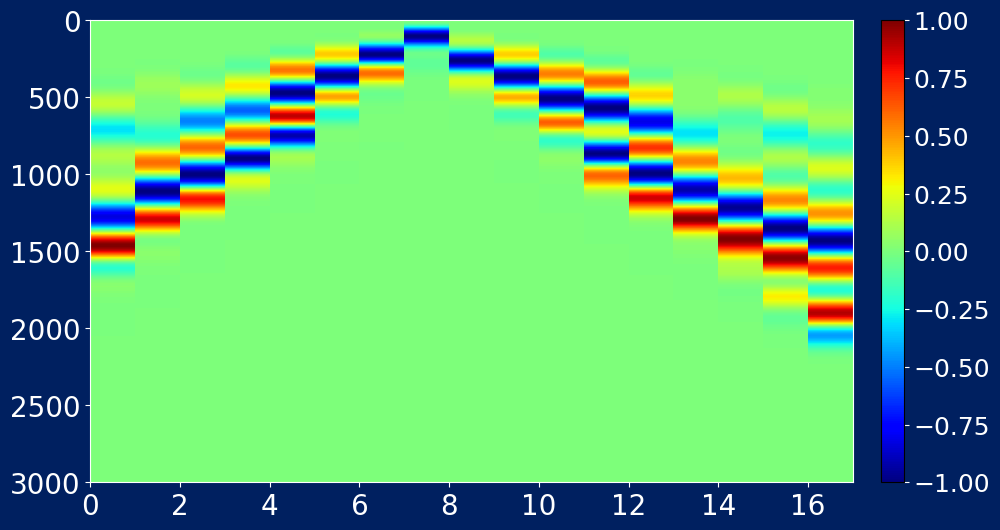

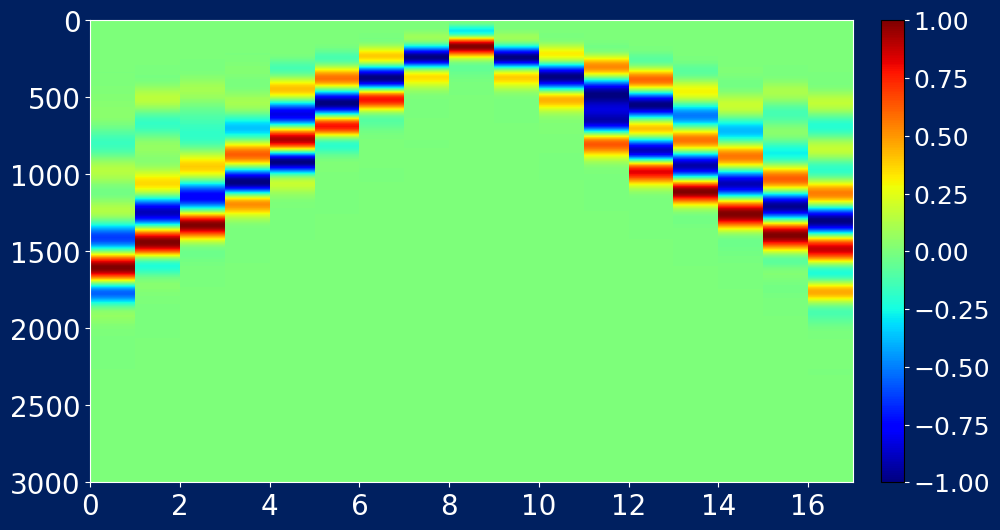

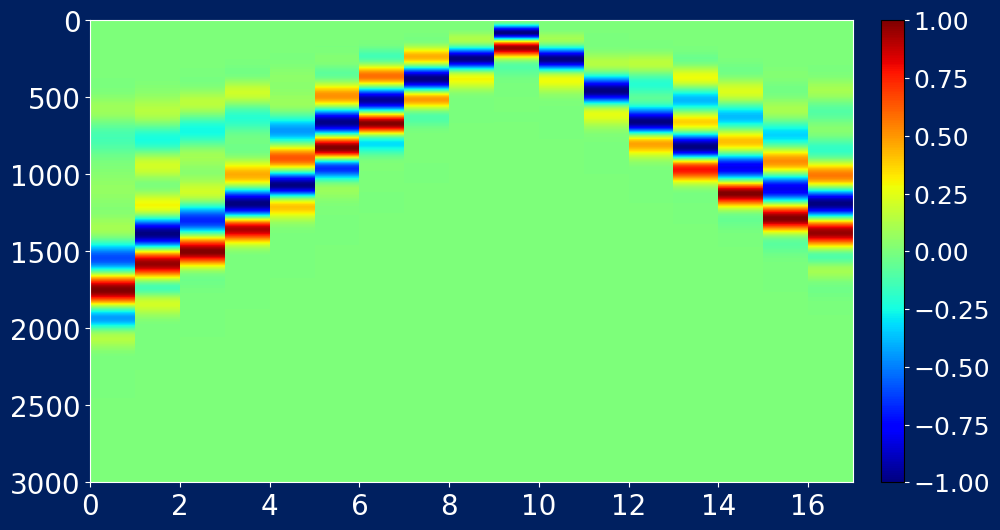

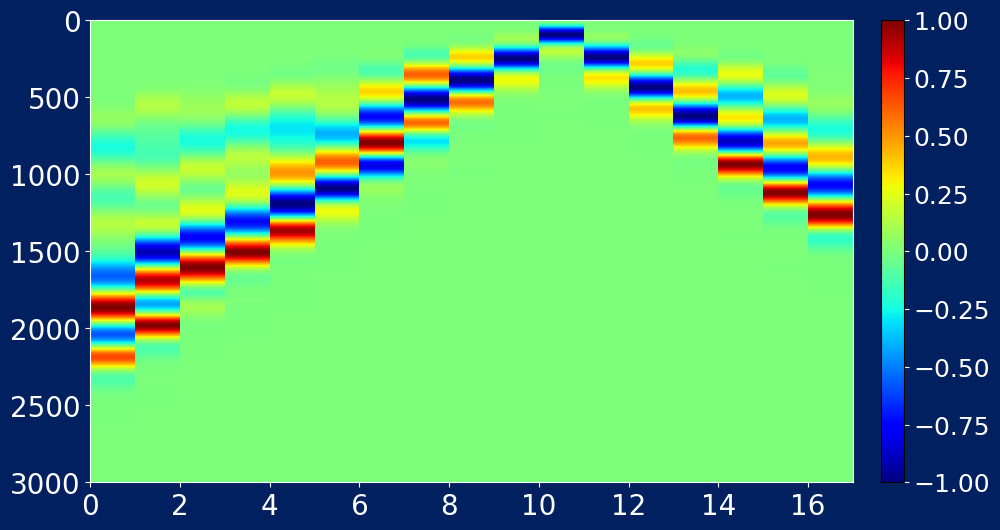

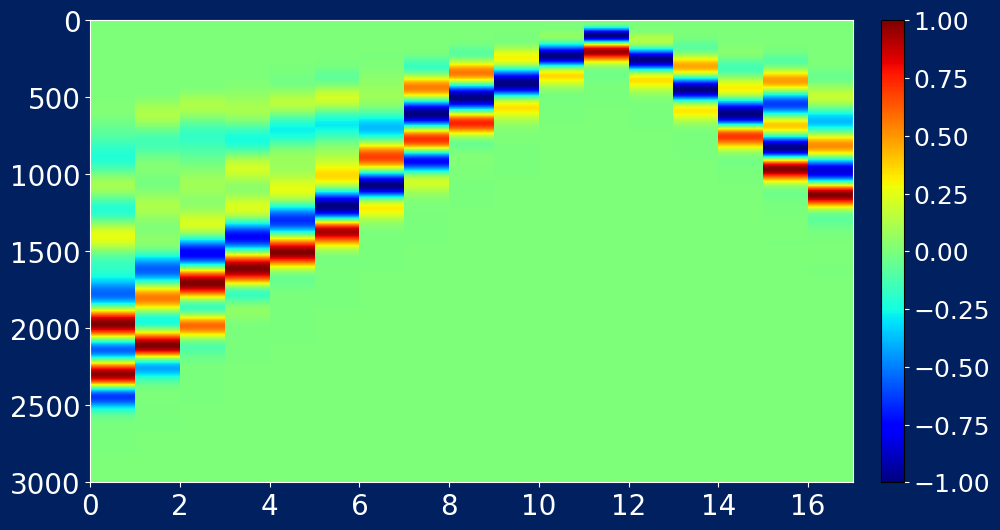

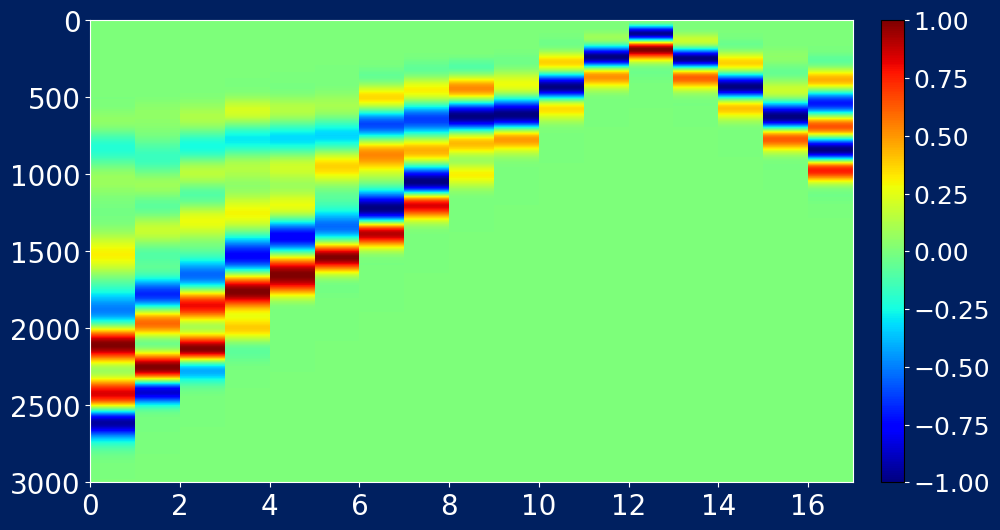

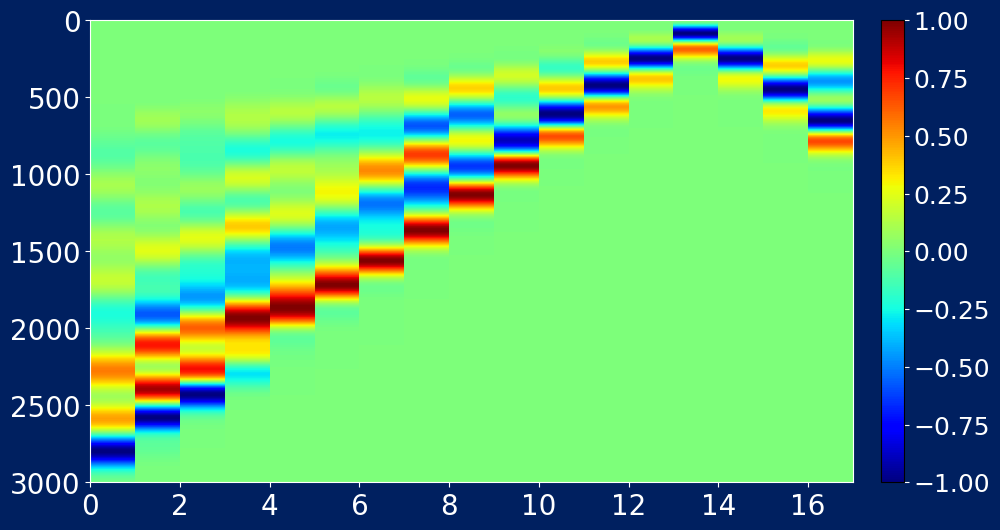

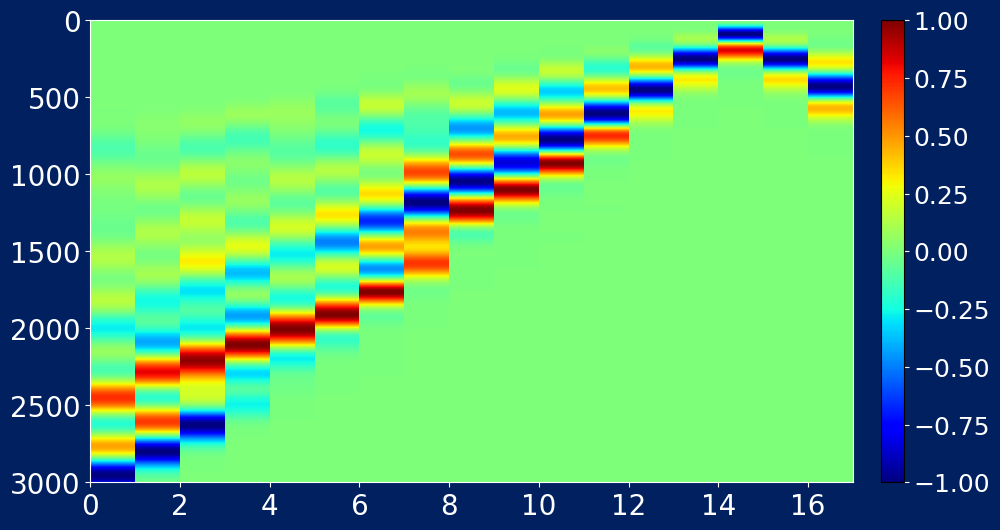

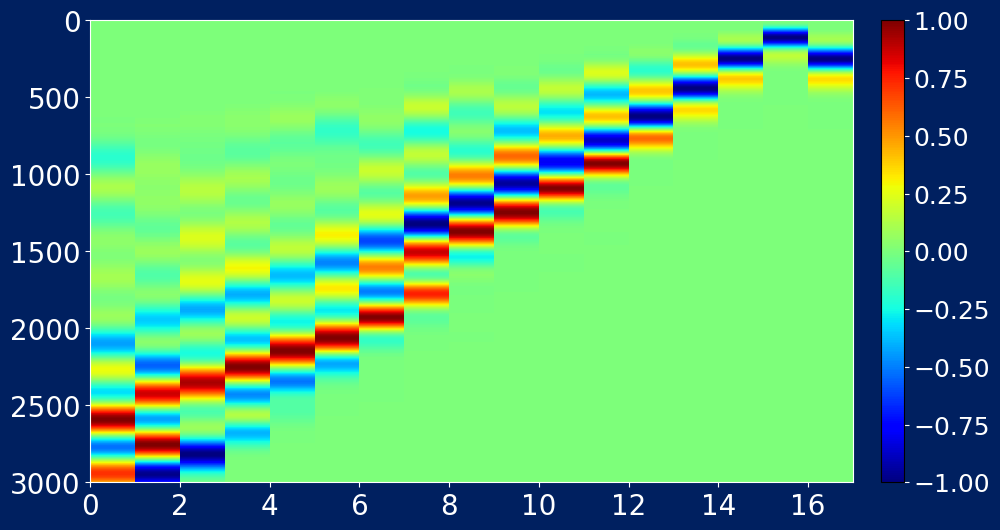

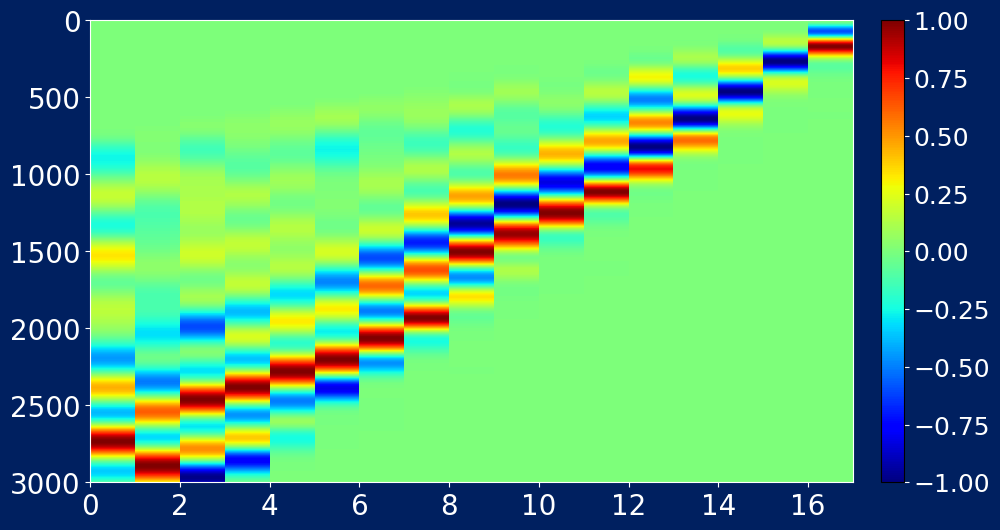

In [13]:
damp=damp_circle(vsmin,nz+pad_top+nbc,nx+nbc+nbc,nbc,dx,1,pad_top)
temp = 1-damp*dt
s = ricker(nt,fr,dt)

dtx = float(dt/dx)

nzbc = nz + nbc + pad_top
nxbc = nx + nbc + nbc
source_type_num = 5
fd_order_num = 22
in_wf = 1
format_num = 2

input_vector = torch.tensor([nt,nzbc,nxbc,dtx,ng,int(sz[0]),int(sx[0]),int(gz[0]),int(gx[0]),int(gx[1]-gx[0]), \
                            source_type_num,fd_order_num,in_wf,nz,nx,format_num,nbc,pad_top])

print('wahtwahtwahtwhatwhtatwhta')
denm2 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc))
denm2[pad_top-1,:]=2*denm2[pad_top-1,:]

denm0 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc))
denm0[pad_top-1,:]=0.0
# serial
device=0

n_proc = ns 
device_num = 5
nbc = int(input_vector[16].clone())
pad_top = int(input_vector[17].clone())
den = pad(torch.ones_like(vp0,device=torch.device('cuda', device)),nbc,pad_top)
dtx = input_vector[3].clone()

for i in range(ns):
    imagesc(seismo_v_d[i,:,:])
    plt.savefig('./dk_vp_iter/vp' + str(i) + '.png')
print(seismo_v_d.device)
torch.save({'seismo_v_d':seismo_v_d.detach().cpu().clone(),'input_vector':input_vector.detach().cpu().clone(), \
            's':s.detach().cpu().clone(),'sx':sx.detach().cpu().clone(),'vp0':vp0.detach().cpu().clone(), \
                'vs0':vs0.detach().cpu().clone(),'temp':temp.detach().cpu().clone(),'denm0':denm0.detach().cpu().clone(), \
                    'denm2':denm2.detach().cpu().clone(),'vpmax':vpmax.detach().cpu().clone(),'vpmin':vpmin.detach().cpu().clone(),\
                        'vsmax':vsmax.detach().cpu().clone(),'vsmin':vsmin.detach().cpu().clone(),\
            'taper':taper.detach().cpu().clone(),'taper1':taper1.detach().cpu().clone()},'./choushuishot2.pt')
print('dx',dx,'dt',dt,'seismo_v_d.shape',seismo_v_d.shape)
print('nbc',nbc,'vpmax',vpmax,'vpmin',vpmin,'vsmax',vsmax,'vsmin',vsmin)

In [14]:
fmax

NameError: name 'fmax' is not defined

In [15]:
!pwd

/home/zhangchang/python/choushuiENFWI
